In [10]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
trainData = pd.read_csv('./train.csv')
testData = pd.read_csv('./test.csv')

## preparing train data
family = pd.DataFrame(0, index=xrange(len(trainData)), columns=['Family'])
for ii in xrange(len(trainData)):
    if (((trainData.SibSp[ii]+trainData.Parch[ii])>0)&((trainData.SibSp[ii]+trainData.Parch[ii])<5)): 
        family.Family[ii]=1
    else:
        if ((trainData.SibSp[ii]+trainData.Parch[ii])>4):
            family.Family[ii]=2

gender = pd.DataFrame(0, index=xrange(len(trainData)), columns=['Gender'])
for ii in xrange(len(trainData)):
    if (trainData.Sex[ii]=='female'): 
        gender.Gender[ii]=1
 

embar = pd.DataFrame(0, index=xrange(len(trainData)), columns=['Embarked']) ## 0 indicates embarked C (i want the two)
### missing values get embarked C which associates with a larger fraction of survival
for ii in xrange(len(trainData)):
    if (trainData.Embarked[ii]=='S'):
        embar.Embarked[ii] = 1
    else:
        if (trainData.Embarked[ii]=='Q'): 
            embar.Embarked[ii] = 2


import re
# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Get all the titles and print how often each one appear.
titles = trainData["Name"].apply(get_title)

titles[(titles=='Capt')|(titles=='Don')|(titles=='Rev')|(titles=='Jonkheer')|(titles=='Dr')|(titles=='Mr')]=0
titles[(titles=='Major')|(titles=='Col')|(titles=='Sir')|(titles=='Master')]=1
titles[(titles=='Ms')|(titles=='Lady')|(titles=='Mme')|(titles=='Mlle')|(titles=='Countess')|(titles=='Mrs')]=2
titles[(titles=='Miss')]=3
 
### No missing values with this matrix, because the Embarked 2 missing values also fixed with C    
newDF = pd.concat([titles,gender.Gender,family.Family,trainData.Pclass,embar.Embarked,
                            trainData.Fare,trainData.Survived],axis=1)


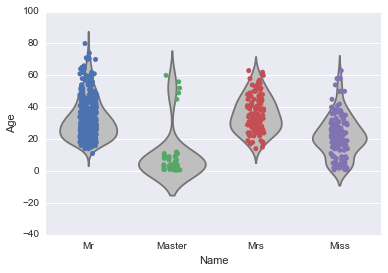

In [69]:
### We have to do imputation for Age
## lets see how mean or median of Age associates with different group

### I want to see how family, title and Fare relates to Age
dataWithAge = pd.concat([trainData.Age,newDF],axis=1)


### titles 
import seaborn as sns
ax = sns.violinplot(x="Name", y="Age", data=dataWithAge, inner=None, color="0.75")
ax = sns.stripplot(x="Name", y="Age", data=dataWithAge, jitter=True ) ## jitter widen the data
ax.set_xticklabels(['Mr','Master','Mrs','Miss'])
#nan_rows = dataWithAge[dataWithAge.isnull().T.any().T]
#nan_rows

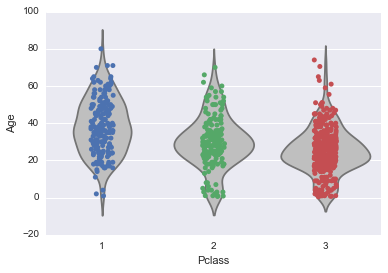

In [70]:
ax = sns.violinplot(x="Pclass", y="Age", data=dataWithAge, inner=None, color="0.75")
ax = sns.stripplot(x="Pclass", y="Age", data=dataWithAge, jitter=True ) 

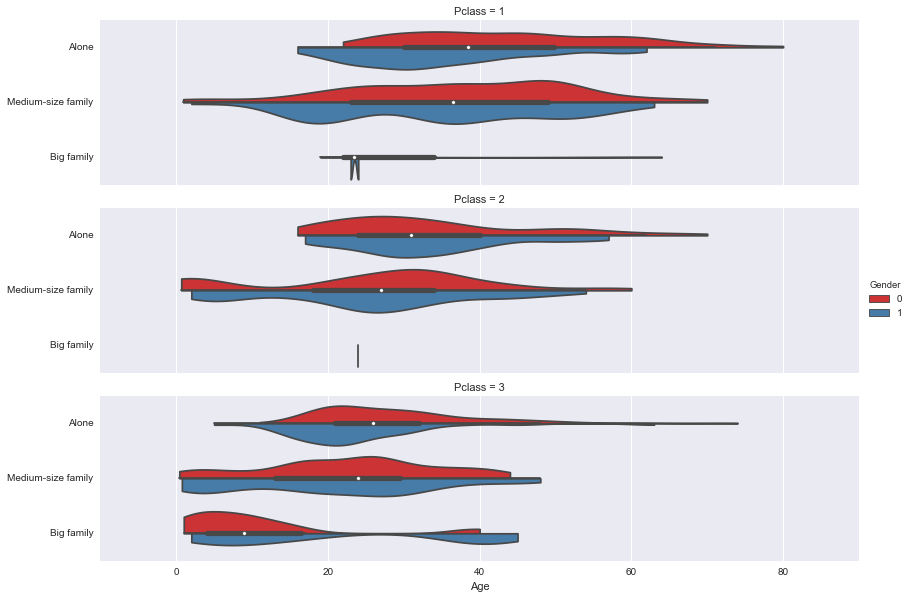

In [63]:
>>> g = sns.factorplot(x="Age", y="Family",
...                    hue="Gender", row="Pclass",
...                    data=dataWithAge,
...                    orient="h", size=2.8, aspect=4.0, palette="Set1",
...                    kind="violin", split=True, cut=0, bw=.3,color="0.75")
#g.set(ylim=(0, 80))
g.set_yticklabels(["Alone", "Medium-size family", "Big family"])
g.set_axis_labels("Age","")
g

In [71]:
### Lets see if I can split the Age based on 4 features of 1) Pclass, 2) Family, 3) titles, 4)Fare...
t = dataWithAge.groupby(['Pclass','Family','Name']).Age.mean()
t

Pclass  Family  Name
1       0       0       44.009804
                1       53.250000
                2       37.000000
                3       33.750000
        1       0       39.341463
                1       16.230000
                2       40.125000
                3       25.947368
        2       0       41.500000
                3       23.500000
2       0       0       33.904762
                2       37.416667
                3       30.694444
        1       0       32.851852
                1        2.258889
                2       32.275862
                3       11.714286
        2       2       24.000000
3       0       0       29.184492
                2       47.000000
                3       22.263889
        1       0       26.959459
                1        5.157778
                2       30.680000
                3        9.750000
        2       0       24.600000
                1        5.466667
                2       40.833333
                3        8.

In [73]:
### replace missing data
dataWithAge.Age.fillna(dataWithAge.groupby(['Pclass','Family','Name']).Age.transform("mean"), inplace=True)
#nan_rows = dataWithAge[dataWithAge.isnull().T.any().T]
#nan_rows

,Age,Name,Gender,Family,Pclass,Embarked,Fare,Survived


In [74]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(dataWithAge, test_size = 0.28)
features_train = train.ix[:,:'Fare']
labels_train = train.Survived
features_test = test.ix[:,:'Fare']
labels_test = test.Survived

from sklearn import tree
clf_DT = tree.DecisionTreeClassifier()
clf_DT.fit( features_train, labels_train )
pred_DT = clf_DT.predict( features_test )

from sklearn.metrics import accuracy_score
print accuracy_score(labels_test,pred_DT)

from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
clf_NB.fit( features_train, labels_train )
pred_NB = clf_NB.predict( features_test )
print accuracy_score(labels_test,pred_NB)

from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(min_samples_split=20)
clf_RF.fit( features_train,labels_train )
pred_RF = clf_RF.predict(features_test)
print accuracy_score(labels_test,pred_RF)

from sklearn.svm import SVC
#clf = SVC(kernel='linear')
clf_svm = SVC(kernel='rbf',C=1.0)   ### 0.990898
clf_svm.fit(features_train, labels_train)
pred_svm = clf_svm.predict(features_test)
print accuracy_score(labels_test,pred_svm)

0.784
0.772
0.82
0.724
